# Classification of Pollen Carrying Bees
### M. Johnson, March 3, 2019
-------

*Note: Be sure to select the py_36_env from the Kernel drop down above.*
 
----

**Optimizer:**
- SGD (over Adam?)

**Batch size:**
- 24

In [1]:
#! pip3.6 install opencv-python

In [2]:
%matplotlib inline
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

#### Dataset
Here we create a custom Dataset object, PollenDataset, to store our data.

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

# 
class PollenDataset(Dataset):
    """class for Pollen dataset."""
    
    # 'pollen_data.csv', base_path
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        '''
        self.root_dir = root_dir
        self.imlist = glob.glob(os.path.join(root_dir, 'images', '*.jpg'))
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        
        # Remove poor sample images
        removed_images = ['NP13068-42r.jpg', 'NP25880-162r.jpg', 'NP27452-203r.jpg', 
                          'NP27452-204r.jpg', 'NP63758-223r.jpg']
        self.removed_df = self.dataframe[ self.dataframe['filename'].isin(removed_images)]
        self.dataframe[ ~self.dataframe['filename'].isin(removed_images)]
        
        self.transform = transform
        self.size =(180,300)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = os.path.join(self.root_dir,
                                'images',
                                self.dataframe.iloc[idx, 0])
        
        image = cv.imread(img_name)
        image2 = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image2, self.size)

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return (image, label)
    
    def get_image(self, idx, removed=False):
        '''
        '''
        
        removed_dict = {False: self.dataframe, 
                        True: self.removed_df}
        
        
        img_name = os.path.join(self.root_dir,
                                'images',
                                removed_dict[removed].iloc[idx,0])
        
        image = cv.imread(img_name)
        image2 = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image2, self.size)

        label = removed_dict[removed].iloc[idx, 1]
        
        return (image, label)

# Class to display random images and labels
# data: Dataset object
def show_random_samples(data):
    
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    fig = plt.figure(figsize=(12, 5))
    
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.tight_layout()
        
        idx = np.random.randint(len(data))
        image, label = data.get_image(idx)
        
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title(label_dict[label])
        plt.xticks([])
        plt.yticks([])
    fig
    
removed_images = ['NP13068-42r.jpg', 'NP27452-203r.jpg', 'NP27452-204r.jpg', 'NP63758-223r.jpg']

def show_removed_samples(data):
    
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    fig = plt.figure(figsize=(8, 4))
    plt.tight_layout()
    
    for i in range(len(removed_images)):
        plt.subplot(1,len(removed_images),i+1)  
        image, label = data.get_image(i, removed=True)
        
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title(label_dict[label] + '\n' + removed_images[i])
        plt.xticks([])
        plt.yticks([])
    fig

### Instantiate the PollenDataset:

In [4]:
from torchvision import transforms

trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,)),
                            transforms.RandomHorizontalFlip(p=0.5),                     
                           ])

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                     mean=[0.24437463, 0.31319633, 0.34366167],
                                     std=[0.12024293, 0.12862892, 0.18092])
                                ])

In [5]:
pollen_data = PollenDataset(csv_file='pollen_data.csv',
                            root_dir='/home/mjohnson/Assignment2/PollenDataset',
                            transform=transforms)

#### A look at some samples:
- potential removals:
    - NP13068-42r.jpg
    - NP25880-162r.jpg
    - NP27452-203r.jpg
    - NP27452-204r.jpg
    - NP63758-223r.jpg <- definitely this one, image has text overlay on it
    - P52861-34r.jpg - also has text overlay, not as bad though ( not removed)

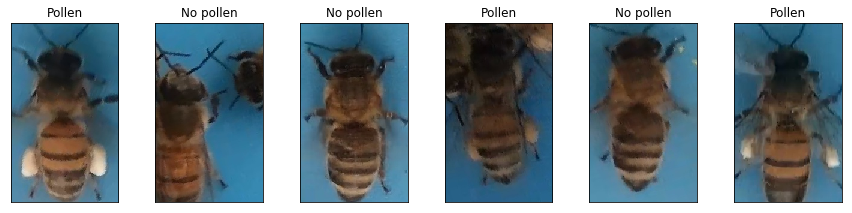

In [6]:
show_random_samples(pollen_data)

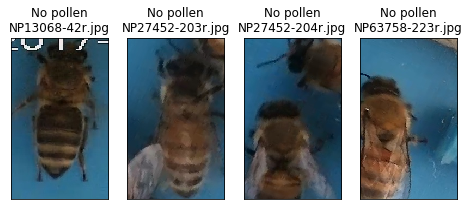

In [7]:
show_removed_samples(pollen_data)

### Model Building:
- 3 Conv layers
- 3 Fully connected layers
- Relus
- 4 MPs

In [8]:
# BNN
#
import torch.nn as nn

class BeeNet(nn.Module):
    def __init__(self):
        super(BeeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)
        self.fc1 = nn.Linear(128*17*9, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape) # [N, 64, 72, 42]
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        #print(x.shape) # [N, 128, 34, 19]
        x = F.relu(F.max_pool2d(x, 2))
        #print(x.shape) # [N, 128, 17, 9]
        x = x.view(-1, 128*17*9)
        #print(x.shape) # 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print(x.shape)
        return F.log_softmax(x, dim=1)

    def name(self):
        return "BeeNet_f28_gpu2"

### Data Loaders

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_indices = []

def get_training_and_validation_loaders(dataset, batch_size = 16, validation_split = .2):
    
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices = val_indices
    
    return train_loader, validation_loader       

In [10]:
# normalization

def get_norm_statistics(dataset, batch_size=64):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    pop_mean = []
    pop_std0 = []
    pop_std1 = []

    for i, (images, labels) in enumerate(dataloader):
        # shape (batch_size, 3, height, width)

        numpy_image = images.numpy()

        # shape (3,)
        batch_mean = np.mean(numpy_image, axis=(0,2,3))
        batch_std0 = np.std(numpy_image, axis=(0,2,3))
        batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)

        pop_mean.append(batch_mean)
        pop_std0.append(batch_std0)
        pop_std1.append(batch_std1)

    # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
    pop_mean = np.array(pop_mean).mean(axis=0)
    pop_std0 = np.array(pop_std0).mean(axis=0)
    pop_std1 = np.array(pop_std1).mean(axis=0)

    return pop_mean, pop_std1

### Model training:
- Note: creates different training/validation sets each time so not to be used with loaded model unless we specify validation set:
    - TODO: specify validation set in way to reuse 

In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
train_loader, validation_loader = get_training_and_validation_loaders(pollen_data, batch_size=24)

In [12]:
device

device(type='cuda')

In [13]:
# HPs
lr = 0.01 # 0.001 too small

# Model
model = BeeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
num_epochs = 40
for epoch in range(num_epochs):
        
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(train_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

Epoch [1/40], Loss: 0.6821, Acc: 0.5
Epoch [2/40], Loss: 0.432, Acc: 0.81
Epoch [3/40], Loss: 0.4318, Acc: 0.81
Epoch [4/40], Loss: 0.3509, Acc: 0.86
Epoch [5/40], Loss: 0.3898, Acc: 0.85
Epoch [6/40], Loss: 0.2824, Acc: 0.9
Epoch [7/40], Loss: 0.2847, Acc: 0.87
Epoch [8/40], Loss: 0.2181, Acc: 0.92
Epoch [9/40], Loss: 0.3663, Acc: 0.87
Epoch [10/40], Loss: 0.2751, Acc: 0.86
Epoch [11/40], Loss: 0.3541, Acc: 0.87
Epoch [12/40], Loss: 0.283, Acc: 0.87
Epoch [13/40], Loss: 0.33, Acc: 0.87
Epoch [14/40], Loss: 0.2127, Acc: 0.92
Epoch [15/40], Loss: 0.2412, Acc: 0.92
Epoch [16/40], Loss: 0.261, Acc: 0.89
Epoch [17/40], Loss: 0.2788, Acc: 0.92
Epoch [18/40], Loss: 0.2179, Acc: 0.93
Epoch [19/40], Loss: 0.26, Acc: 0.89
Epoch [20/40], Loss: 0.2374, Acc: 0.92
Epoch [21/40], Loss: 0.2552, Acc: 0.91
Epoch [22/40], Loss: 0.2279, Acc: 0.91
Epoch [23/40], Loss: 0.2435, Acc: 0.93
Epoch [24/40], Loss: 0.1964, Acc: 0.94
Epoch [25/40], Loss: 0.256, Acc: 0.92
Epoch [26/40], Loss: 0.2576, Acc: 0.92
Epoch

## Loss and Accuracy 

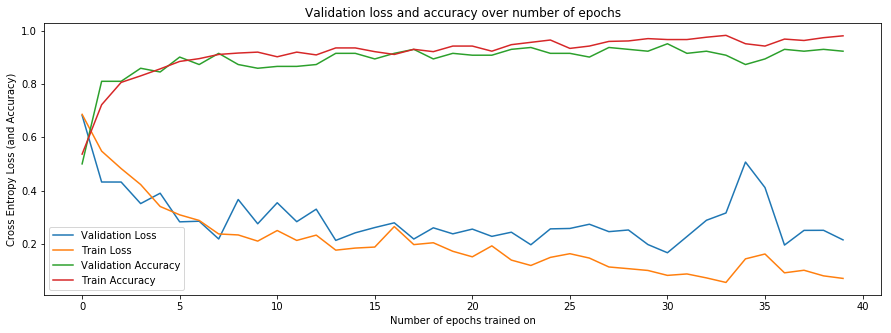

In [14]:
plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(train_losses);
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title('Validation loss and accuracy over number of epochs');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend(['Validation Loss', 'Train Loss', 'Validation Accuracy', 'Train Accuracy'], loc='lower left');

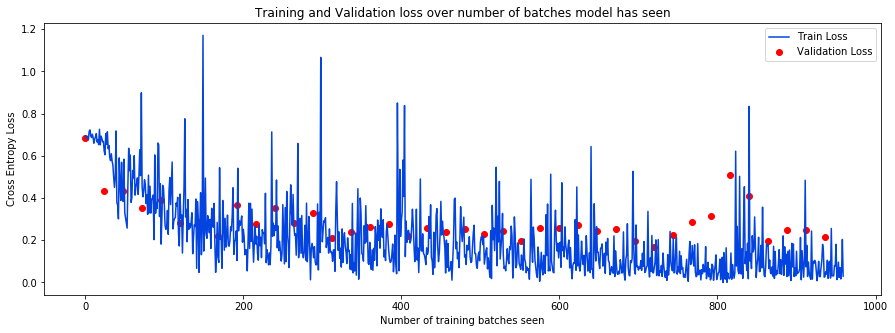

In [15]:
loader_len = len(train_loader)
x_vals= [loader_len*i for i in range(num_epochs)]
y_vals = loss_list

plt.subplots(figsize=(15,5))
plt.plot(train_losses2, color='xkcd:blue');
plt.scatter(x=x_vals, y=loss_list, color='red'); # validation losses
#plt.scatter(x=x_vals, y=acc_list, color='xkcd:green') # accs
plt.title('Training and Validation loss over number of batches model has seen');
plt.xlabel('Number of training batches seen');
plt.ylabel('Cross Entropy Loss');
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right');

### - Looks like it may be starting to overfit after ~ 300-350 batches



<br>

In [16]:
torch.save(model.state_dict(), 'm3_BeeNet_sgd.pth')
torch.save(optimizer.state_dict(), 'm3_optim_sgd.pth')

## Model Evaluation

In [17]:
# Test
model.eval()

total = 0
correct = 0
testlosses = []
correct_labels = []
predictions = []

with torch.no_grad():
    
    for batch_index, (images, labels) in enumerate(validation_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)
        
        testlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
        correct_labels.extend(labels)
        predictions.extend(argmax)
        

test_loss = np.mean(testlosses)
accuracy = np.round(correct/total, 2)
print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

Loss: 0.1898, Acc: 0.94


In [18]:
from sklearn.metrics import confusion_matrix

y_true = [label.item() for label in correct_labels]
y_pred = [label.item() for label in predictions]

cm = confusion_matrix(y_true, y_pred)

cm

array([[77,  3],
       [ 6, 56]])

### Confusion Matrix

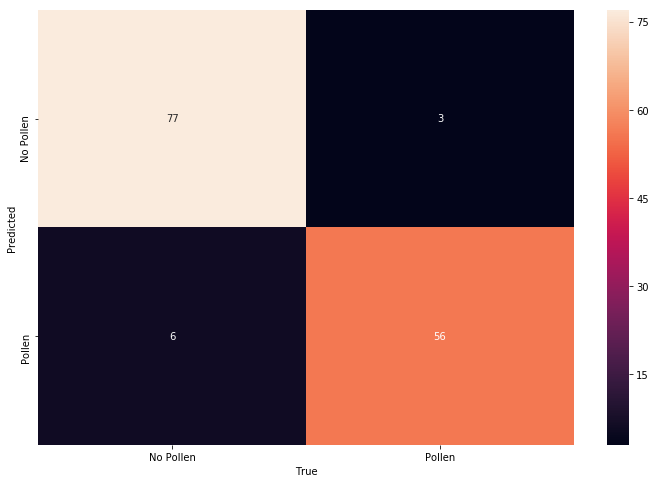

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12,8));
sns.heatmap(cm, annot=True, fmt='g', yticklabels=['No Pollen', 'Pollen'],
            xticklabels=['No Pollen', 'Pollen']);

plt.xlabel('True');
plt.ylabel('Predicted');

### Classification Report

In [20]:
from sklearn.metrics import classification_report

target_names = ['No Pollen', 'Pollen']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Pollen       0.93      0.96      0.94        80
      Pollen       0.95      0.90      0.93        62

   micro avg       0.94      0.94      0.94       142
   macro avg       0.94      0.93      0.94       142
weighted avg       0.94      0.94      0.94       142



### A look at predictions

In [21]:
import warnings
warnings.filterwarnings('ignore')
                        
def show_predictions(rows=2):
    
    with torch.no_grad():
    
        # Chooose a random batch from validation loader to predict
        which_iter = np.random.randint(len(validation_loader))
        valid_iter = iter(validation_loader)
        for i in range(which_iter-1):
            next(valid_iter)

        # Fetch images and labels from batch
        images, labels = next(valid_iter)
        images, labels = images.to(device), labels.to(device)
        # 
        #outputs = model(images.permute(0, 3, 2, 1).float())
        outputs = model(images.float())
        predictions = torch.max(outputs, 1)[1]
        predictions = predictions.cpu().numpy()

        labels = labels.cpu().numpy()

        # Dict for Labelling Images
        label_dict = {0: 'No pollen', 1: 'Pollen'}
        color_dict = {True: 'green', False: 'red'}
        
        fig = plt.figure(figsize=(15, 6))

        for i in range(6*rows):
            plt.subplot(rows,6,i+1)
            plt.tight_layout()

            image, label, pred = images[i], labels[i], predictions[i]

            plt.imshow(image.permute(1,2,0).cpu().numpy(), cmap='gray', interpolation='none')
            
            plt.title('Label:' + label_dict[label] + '\nPred:' + label_dict[pred], 
                      color=color_dict[(label_dict[label] == label_dict[pred])])
            plt.xticks([])
            plt.yticks([])
        fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

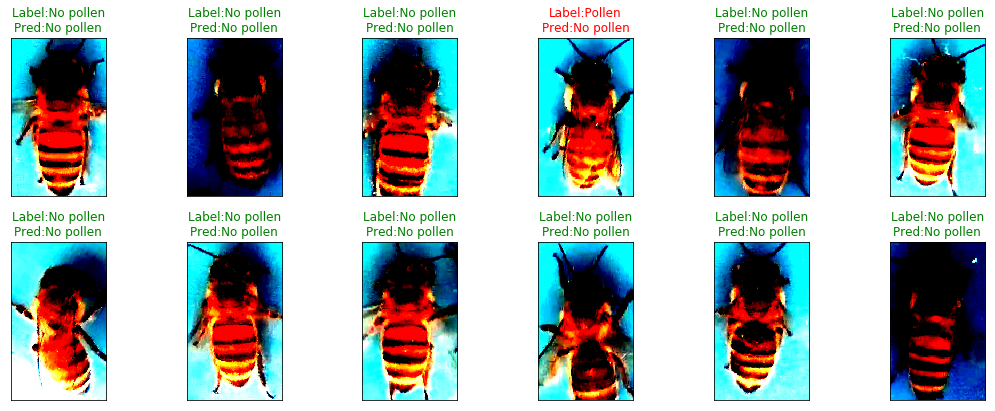

In [22]:
show_predictions()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

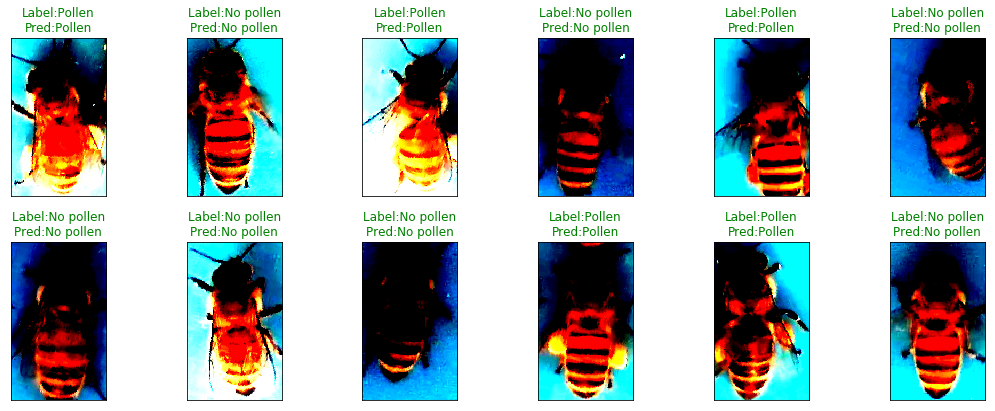

In [23]:
show_predictions()